In [1]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import emd
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from statistics import mean
import statistics
from dateutil.parser import parse
import statistics as st

from src.data import nysm_data

In [3]:
from datetime import datetime

datetime.now()

datetime.datetime(2024, 8, 29, 14, 18, 27, 728373)

In [4]:
nysm_df = nysm_data.load_nysm_data()

/home/aevans/nwp_bias/src/machine_learning/notebooks/../src/data/nysm_data.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nysm_1H_obs['snow_depth'].fillna(-999, inplace=True)


In [5]:
triangles = [
    "BSPA",
    "BUFF",
    "CROG",
    "ESSX",
    "GROT",
    "HARP",
    "HERK",
    "POTS",
    "RAND",
    "STON",
]

In [6]:
triangle_nysm = nysm_df[nysm_df["station"].isin(triangles)]

In [7]:
triangle_nysm = triangle_nysm[triangle_nysm["time_1H"] > datetime(2020, 8, 26, 7, 0, 0)]
triangle_nysm = triangle_nysm[triangle_nysm["time_1H"] < datetime(2020, 8, 29, 3, 0, 0)]

In [8]:
triangle_nysm

,station,time_1H,lat,lon,elev,tair,ta9m,td,relh,srad,pres,mslp,wspd_sonic_mean,wspd_sonic,wmax_sonic,wdir_sonic,snow_depth,precip_total
655880,BSPA,2020-08-26 08:00:00,43.022800,-73.874977,120.517998,12.322200,12.740660,8.996674,80.130417,0.000000,999.118774,999.492065,0.943401,0.866603,1.256254,288.798401,-999.0,0.0
655881,BSPA,2020-08-26 09:00:00,43.022800,-73.874977,120.517998,11.131720,12.201570,9.083740,87.196358,0.000000,999.565613,1000.001404,0.922018,0.952720,1.586694,288.927704,-999.0,0.0
655882,BSPA,2020-08-26 10:00:00,43.022800,-73.874977,120.517998,10.552780,11.953450,8.813507,88.981247,0.674864,1000.109985,1000.577148,1.234016,1.328556,2.246809,289.477814,-999.0,0.0
655883,BSPA,2020-08-26 11:00:00,43.022800,-73.874977,120.517998,11.346440,11.909390,9.013031,85.554718,23.419249,1000.466003,1000.893127,1.297324,1.003778,1.809671,291.614685,-999.0,0.0
655884,BSPA,2020-08-26 12:00:00,43.022800,-73.874977,120.517998,14.114090,14.097770,8.950104,71.059959,237.766907,1000.841003,1001.128174,2.328292,1.490497,3.997994,277.309113,-999.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722156,STON,2020-08-28 20:00:00,40.919121,-73.131683,43.921700,27.998560,27.778061,17.301270,52.203110,517.713440,1004.007996,1004.060730,2.164566,2.129330,3.556499,324.378113,-999.0,0.0
722157,STON,2020-08-28 21:00:00,40.919121,-73.131683,43.921700,28.348471,28.144880,17.135651,50.615620,271.790405,1003.781006,1003.827637,0.870820,1.723410,2.929441,272.532898,-999.0,0.0
722158,STON,2020-08-28 22:00:00,40.919121,-73.131683,43.921700,26.624969,27.551069,18.563446,61.263672,77.050545,1003.447021,1003.523071,1.225164,0.512785,0.682504,194.375198,-999.0,0.0
722159,STON,2020-08-28 23:00:00,40.919121,-73.131683,43.921700,25.445049,25.467430,19.961273,71.677650,33.391567,1003.861023,1003.958008,1.964557,1.464407,3.919325,211.218796,-999.0,0.0


In [9]:
# triangle_nysm.to_csv(
#     "/home/aevans/nwp_bias/src/machine_learning/notebooks/nwp_nysm.csv"
# )

In [10]:
# exp_df = pd.DataFrame()
# for i in np.arange(0, 5):
#     df = pd.read_csv(
#         f"/home/aevans/nwp_bias/src/machine_learning/notebooks/bkln/bkln_{i}.csv"
#     )
#     exp_df = pd.concat([df, exp_df])

In [11]:
# my_stations = exp_df["station"].unique()

In [12]:
# my_stations

In [13]:
# my_stations = np.delete(my_stations, 0)
# my_stations = np.delete(my_stations, 6)
# my_stations = np.delete(my_stations, -3)

In [14]:
my_stations = triangles

In [15]:
# exp_df = exp_df.sort_values("forecast_hour")

In [16]:
# bkln_df = exp_df[exp_df["station"] == "BKLN"]
# want_df = exp_df[exp_df["station"] == "WANT"]
# tyro_df = exp_df[exp_df["station"] == "TYRO"]
# wall_df = exp_df[exp_df["station"] == "WALL"]
# medu_df = exp_df[exp_df["station"] == "MEDU"]
# addi_df = exp_df[exp_df["station"] == "ADDI"]
# fred_df = exp_df[exp_df["station"] == "FRED"]
# ches_df = exp_df[exp_df["station"] == "CHES"]
# oppe_df = exp_df[exp_df["station"] == "OPPE"]
# gabr_df = exp_df[exp_df["station"] == "GABR"]
# loui_df = exp_df[exp_df["station"] == "LOUI"]

In [17]:
# fig, ax = plt.subplots(figsize=(24, 9))
# plt.title("Forecast Hour Drift", fontsize=28)
# plt.xlabel("HRRR Forecast Hour", fontsize=18)
# plt.ylabel("Min Test Loss", fontsize=18)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# # stations
# plt.plot(
#     bkln_df["forecast_hour"],
#     bkln_df["test_loss (Min)"],
#     c="indigo",
#     marker="d",
#     markersize=12,
#     linewidth=2,
#     label="Brooklyn",
#     zorder=7,
# )
# plt.plot(
#     want_df["forecast_hour"],
#     want_df["test_loss (Min)"],
#     c="olive",
#     marker="v",
#     markersize=12,
#     linewidth=2,
#     label="Wantagh",
#     zorder=7,
#     alpha=0.4,
# )
# plt.plot(
#     tyro_df["forecast_hour"],
#     tyro_df["test_loss (Min)"],
#     c="forestgreen",
#     marker="o",
#     markersize=12,
#     linewidth=2,
#     label="Tyrone",
#     zorder=7,
#     alpha=0.4,
# )
# plt.plot(
#     wall_df["forecast_hour"],
#     wall_df["test_loss (Min)"],
#     c="goldenrod",
#     marker="s",
#     markersize=12,
#     linewidth=2,
#     label="Wallkill",
#     zorder=7,
#     alpha=0.4,
# )
# plt.plot(
#     medu_df["forecast_hour"],
#     medu_df["test_loss (Min)"],
#     c="teal",
#     marker="^",
#     markersize=12,
#     linewidth=2,
#     label="Medusa",
#     zorder=7,
#     alpha=0.4,
# )
# plt.plot(
#     addi_df["forecast_hour"],
#     addi_df["test_loss (Min)"],
#     c="darkred",
#     marker="X",
#     markersize=12,
#     linewidth=2,
#     label="Addison",
#     zorder=7,
#     alpha=1.0,
# )
# plt.plot(
#     fred_df["forecast_hour"],
#     fred_df["test_loss (Min)"],
#     c="sienna",
#     marker="p",
#     markersize=12,
#     linewidth=2,
#     label="Fredonia",
#     zorder=7,
#     alpha=0.4,
# )
# plt.plot(
#     ches_df["forecast_hour"],
#     ches_df["test_loss (Min)"],
#     c="darkorange",
#     marker="P",
#     markersize=12,
#     linewidth=2,
#     label="Chestertown",
#     zorder=7,
#     alpha=1.0,
# )

# plt.plot(
#     oppe_df["forecast_hour"],
#     oppe_df["test_loss (Min)"],
#     c="royalblue",
#     marker="<",
#     markersize=12,
#     linewidth=2,
#     label="Oppenheim",
#     zorder=7,
#     alpha=1.0,
# )
# plt.plot(
#     gabr_df["forecast_hour"],
#     gabr_df["test_loss (Min)"],
#     c="violet",
#     marker=">",
#     markersize=12,
#     linewidth=2,
#     label="Gabriels",
#     zorder=7,
# )
# plt.plot(
#     loui_df["forecast_hour"],
#     loui_df["test_loss (Min)"],
#     c="deeppink",
#     marker="D",
#     markersize=12,
#     linewidth=2,
#     label="Louisville",
#     zorder=7,
# )
# plt.legend(bbox_to_anchor=(1.1, 1), loc="upper left", borderaxespad=0, fontsize=16)

In [18]:
for i in np.arange(2, 19, 2):
    print(i)

2
4
6
8
10
12
14
16
18


In [19]:
nysm_cats_path = "/home/aevans/nwp_bias/src/landtype/data/nysm.csv"

nysm_cats_df = pd.read_csv(nysm_cats_path)

In [20]:
# triangles = ["BRON", "BUFF", "ANDE", "WALL"]
triangle = nysm_cats_df[nysm_cats_df["stid"].isin(triangles)]

triangle
# # nysm_cats_df = nysm_cats_df[nysm_cats_df["stid"].isin(my_stations)]
# nysm_cats_df

,stid,number,name,lat [degrees],lon [degrees],elevation [m],county,nearest_city,state,distance_from_town [km],direction_from_town [degrees],climate_division,climate_division_name,wfo,commissioned,decommissioned
15,BSPA,97,Ballston Spa,43.022800,-73.874980,120.5180,Saratoga,Ballston Spa,NY,3.20,NW,5,Hudson Valley,ALY,2016-08-18 16:40:00 UTC,NaN
16,BUFF,4,Buffalo,43.000170,-78.767170,179.5880,Erie,Buffalo,NY,15.60,NE,9,Great Lakes,BUF,2017-03-09 21:20:00 UTC,NaN
32,CROG,51,Croghan,43.974960,-75.201000,418.9480,Lewis,Croghan,NY,17.70,ENE,3,Northern Plateau,BUF,2016-11-02 18:50:00 UTC,NaN
44,ESSX,13,Essex,44.313604,-73.371896,55.5000,Essex,Essex,NY,1.60,WNW,7,Champlain Valley,BTV,2015-12-05 21:15:00 UTC,NaN
50,GROT,41,Groton,42.548550,-76.375340,392.2470,Tompkins,Groton,NY,4.40,S,10,Central Lakes,BGM,2016-12-21 19:40:00 UTC,NaN
53,HARP,101,Harpersfield,42.472800,-74.698490,519.8970,Delaware,Harpersfield,NY,4.00,NNW,2,Eastern Plateau,BGM,2016-08-04 19:55:00 UTC,NaN
56,HERK,50,Herkimer,43.036620,-75.009570,217.5360,Herkimer,Herkimer,NY,2.20,WNW,6,Mohawk Valley,ALY,2016-08-10 01:10:00 UTC,NaN
83,POTS,22,Potsdam,44.656867,-74.974433,128.6870,St. Lawrence,Potsdam,NY,1.50,SSE,8,St. Lawrence Valley,BTV,2016-07-08 01:45:00 UTC,NaN
85,RAND,125,Randolph,42.149280,-78.900960,448.9700,Cattaraugus,Randolph,NY,6.30,ESE,1,Western Plateau,BUF,2016-06-02 15:50:00 UTC,NaN
104,STON,2,Stony Brook,40.919120,-73.131680,43.9217,Suffolk,Stony Brook,NY,1.06,SE,4,Coastal,OKX,2018-02-21 15:35:00 UTC,NaN


In [21]:
# df_ = nysm_cats_df[nysm_cats_df["climate_division_name"] == "Western Plateau"]
# my_stations = df_["stid"].unique()

In [22]:
# my_stations
df_ = triangle

BSPA
forestgreen
0
BUFF
olive
1
CROG
goldenrod
2
ESSX
teal
3
GROT
darkred
4
HARP
indigo
5
HERK
sienna
6
POTS
darkorange
7
RAND
royalblue
8
STON
violet
9


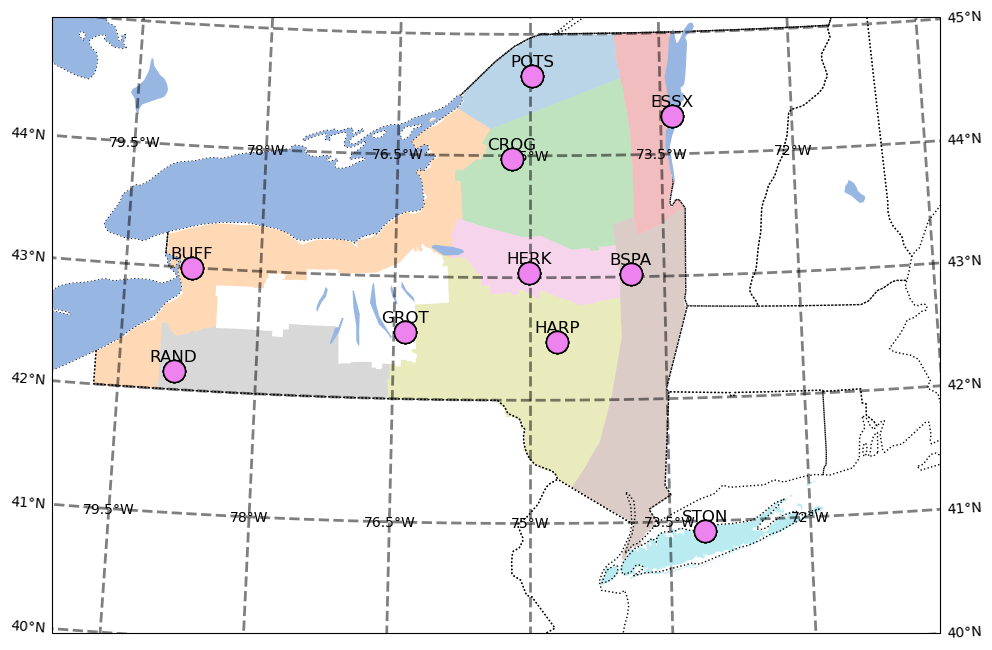

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

colors = [
    "forestgreen",
    "olive",
    "goldenrod",
    "teal",
    "darkred",
    "indigo",
    "sienna",
    "darkorange",
    "royalblue",
    # "deeppink",
    "violet",
]
j = 0

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(
    1,
    1,
    1,
    projection=ccrs.LambertConformal(
        central_longitude=-75.0, standard_parallels=(49, 77)
    ),
)

# Replace 'your_shapefile.shp' with the path to your shapefile
shapefile_path = "/home/aevans/nwp_bias/src/machine_learning/notebooks/data/GIS.OFFICIAL_CLIM_DIVISIONS.shp"

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Load the boundaries of New York State (replace with your actual file path)
ny_state_boundaries_path = "/home/aevans/nwp_bias/src/landtype/data/State.shx"

# Read the shapefile and set the CRS explicitly
ny_state_boundaries_geo = gpd.read_file(ny_state_boundaries_path).to_crs(epsg=4326)

# Get the bounding box of New York State
ny_bbox = ny_state_boundaries_geo.total_bounds

# Filter the GeoDataFrame to include only polygons within New York State
gdf_filtered = gdf.cx[ny_bbox[0] : ny_bbox[2], ny_bbox[1] : ny_bbox[3]]
gdf_filtered = gdf_filtered.iloc[20:29]

# Create a categorical column for coloring
gdf_filtered["category"] = np.arange(len(gdf_filtered))

# Plot the shapefile with multiple colors based on the 'category' column
gdf_filtered.plot(
    ax=ax, transform=ccrs.PlateCarree(), column="category", cmap="tab10", alpha=0.3
)

# Set extent for the plot
ax.set_extent([-80.0, -70.7, 40.0, 45.0], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.BORDERS.with_scale("50m"), linestyle=":", zorder=1)
ax.add_feature(cfeature.STATES.with_scale("50m"), linestyle=":", zorder=1)
ax.add_feature(cfeature.LAKES.with_scale("50m"), zorder=1)
ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=2,
    color="black",
    alpha=0.5,
    linestyle="--",
)
ax.xticklabels_top = False
ax.ylabels_right = False

# Annotate scatter points with station IDs
for i, row in df_.iterrows():
    lon, lat = row["lon [degrees]"], row["lat [degrees]"]
    ax.annotate(
        row["stid"],
        (lon, lat),
        textcoords="offset points",
        xytext=(0, 7),
        ha="center",
        fontsize=12,
        color="black",
        transform=ccrs.PlateCarree(),
    )

# Plot scatter points
for j, s in enumerate(triangles):
    print(s)
    print(colors[j])
    # df = nysm_cats_df[nysm_cats_df["stid"] == s]
    ax.scatter(
        df_["lon [degrees]"],
        df_["lat [degrees]"],
        c=colors[j],
        s=250,
        edgecolors="black",
        transform=ccrs.PlateCarree(),
        zorder=10,
        label=s,
    )
    print(j)
    j += 1

# Display the plot
plt.show()

In [24]:
# need 0 row
gdf_filtered_1 = gdf_filtered.iloc[20:30]
gdf_filtered_1

,geometry,category


/tmp/tmp.gbtM5VcZzi/ipykernel_855487/4221669527.py:11: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf_filtered_1.plot(


<GeoAxes: >

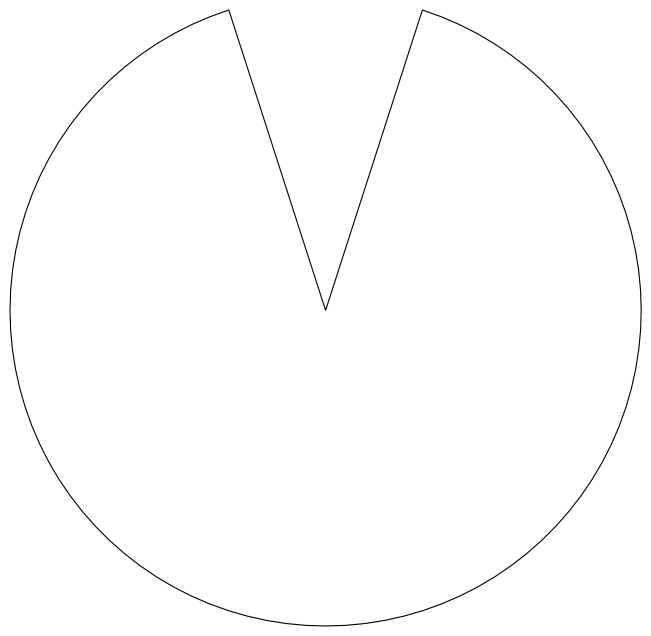

In [25]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(
    1,
    1,
    1,
    projection=ccrs.LambertConformal(
        central_longitude=-75.0, standard_parallels=(49, 77)
    ),
)
# Plot the shapefile with multiple colors based on the 'category' column
gdf_filtered_1.plot(
    ax=ax, transform=ccrs.PlateCarree(), column="category", cmap="gist_ncar", alpha=0.3
)

In [26]:
import rasterio
import cartopy.crs as crs
import cartopy.feature as cfeature

# Replace 'ny_dem.tif' with the path to your downloaded DEM file
ny_dem = "/home/aevans/nwp_bias/src/landtype/data/Map.tif"
colors = [
    "forestgreen",
    "olive",
    "goldenrod",
    "teal",
    "darkred",
    "indigo",
    "sienna",
    "darkorange",
    "royalblue",
    "violet",
    "deeppink",
]
j = 0

skip = 5

# Open the DEM file using rasterio
with rasterio.open(ny_dem) as src:
    elevation_data = src.read(
        1
    )  # Read the first band (assuming it's the elevation data)
    elevation_transform = src.transform
# Get the number of rows and columns in the elevation data
rows, cols = elevation_data.shape

# Create 2D arrays of coordinates using numpy.meshgrid
lons, lats = np.meshgrid(
    np.linspace(
        elevation_transform[2],
        elevation_transform[2] + cols * elevation_transform[0],
        cols,
    ),
    np.linspace(
        elevation_transform[5],
        elevation_transform[5] + rows * elevation_transform[4],
        rows,
    ),
)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(
    1,
    1,
    1,
    projection=crs.LambertConformal(
        central_longitude=-75.0, standard_parallels=(49, 77)
    ),
)

# ax.add_feature(cfeature.LAND.with_scale('50m'), zorder=3)
ax.add_feature(cfeature.OCEAN.with_scale("50m"), zorder=1)
ax.add_feature(cfeature.BORDERS.with_scale("50m"), linestyle=":", zorder=1)
ax.add_feature(cfeature.STATES.with_scale("50m"), linestyle=":", zorder=1)
ax.add_feature(cfeature.LAKES.with_scale("50m"), zorder=1)
ax.gridlines(
    crs=crs.PlateCarree(),
    draw_labels=True,
    linewidth=2,
    color="black",
    alpha=0.5,
    linestyle="--",
)
ax.xticklabels_top = False
ax.ylabels_right = False

plt.contourf(
    lons[::skip, ::skip],
    lats[::skip, ::skip],
    elevation_data[::skip, ::skip],
    transform=crs.PlateCarree(),
    levels=np.arange(0, 1500, 100),
    cmap="gist_earth_r",
    zorder=0,
)
for s in my_stations:
    df = nysm_cats_df[nysm_cats_df["stid"] == s]
    plt.scatter(
        df["lon [degrees]"],
        df["lat [degrees]"],
        c=colors[j],
        s=250,
        edgecolors="black",
        transform=crs.PlateCarree(),
        zorder=10,
        label=s,
    )
    j += 1

ax.set_extent([-79.82, -72.0, 40.48, 44.9])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.legend(bbox_to_anchor=(1.1, 1), loc="upper left", borderaxespad=0, fontsize=16)

ModuleNotFoundError: No module named 'rasterio'

In [ ]:
def load_nysm_data():
    # these parquet files are created by running "get_resampled_nysm_data.ipynb"
    nysm_path = "/home/aevans/nwp_bias/data/nysm/"

    nysm_1H = []
    for year in np.arange(2018, 2023):
        df = pd.read_parquet(f"{nysm_path}nysm_1H_obs_{year}.parquet")
        df.reset_index(inplace=True)
        nysm_1H.append(df)
    nysm_1H_obs = pd.concat(nysm_1H)
    nysm_1H_obs["snow_depth"] = nysm_1H_obs["snow_depth"].fillna(0)
    nysm_1H_obs.fillna(-999, inplace=True)
    return nysm_1H_obs

In [ ]:
nysm_df = load_nysm_data()

In [ ]:
stations = ["ANDE", "BRON", "BUFF", "WALL"]

In [ ]:
nysm_df = nysm_df[nysm_df["station"].isin(stations)]

In [ ]:
nysm_df = nysm_df[nysm_df["time_1H"] > datetime(2020, 8, 26, 0, 0, 0)]
nysm_df = nysm_df[nysm_df["time_1H"] < datetime(2020, 8, 29, 0, 0, 0)]

In [ ]:
nysm_df

In [ ]:
def plot_weather(df, var):
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.set_xlabel(f"Time", fontsize=18)
    ax.set_ylabel(f"{var} [m/s]", fontsize=18)
    ax.set_title(f"{df['station'].iloc[0]}", fontsize=24)
    plt.ylim([0, 20])

    plt.plot(df["time_1H"], df[var], c="red")

In [ ]:
temp_1 = nysm_df[nysm_df["station"] == "ANDE"]
temp_2 = nysm_df[nysm_df["station"] == "BUFF"]
temp_3 = nysm_df[nysm_df["station"] == "BRON"]
temp_4 = nysm_df[nysm_df["station"] == "WALL"]

In [ ]:
plot_weather(temp_1, "wmax_sonic")

In [ ]:
plot_weather(temp_2, "wmax_sonic")

In [ ]:
plot_weather(temp_3, "wmax_sonic")

In [ ]:
plot_weather(temp_4, "wmax_sonic")

In [ ]:
def read_hrrr_data():
    """
    Reads and concatenates parquet files containing forecast and error data for HRRR weather models
    for the years 2018 to 2022.

    Returns:
        pandas.DataFrame: of hrrr weather forecast information for each NYSM site.
    """

    years = ["2018", "2019", "2020", "2021", "2022"]
    savedir = "/home/aevans/ai2es/processed_data/HRRR/ny/"

    # create empty lists to hold dataframes for each model
    hrrr_fcast_and_error = []

    # loop over years and read in parquet files for each model
    for year in years:
        for month in np.arange(1, 13):
            str_month = str(month).zfill(2)
            if (
                os.path.exists(
                    f"{savedir}HRRR_{year}_{str_month}_direct_compare_to_nysm_sites_mask_water.parquet"
                )
                == True
            ):
                hrrr_fcast_and_error.append(
                    pd.read_parquet(
                        f"{savedir}HRRR_{year}_{str_month}_direct_compare_to_nysm_sites_mask_water.parquet"
                    )
                )
            else:
                continue

    # concatenate dataframes for each model
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index().dropna()

    # return dataframes for each model
    return hrrr_fcast_and_error_df

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd


def format_climate_df(data_path):
    """
    Formats a climate data file located at the specified `data_path` into a pandas DataFrame.

    Args:
        data_path (str): The file path for the climate data file.

    Returns:
        pandas.DataFrame: A DataFrame containing the climate data, with the first column renamed to "year".
    """
    raw_index = np.loadtxt(f"{data_path}")
    cl_index = pd.DataFrame(raw_index)
    cl_index = cl_index.rename(columns={0: "year"})
    return cl_index

In [ ]:
def groupby_month(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.year), (df.valid_time.dt.month)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    plt.plot(the_list)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    ax.set_xticks(np.arange(0, len(the_list), int(len(the_list) / 5)))
    return the_list

In [ ]:
def groupby_month_hrrr(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.time.dt.year), (df.time.dt.month)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    plt.plot(the_list)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    ax.set_xticks(np.arange(0, 60, 12))
    return the_list

In [ ]:
def anoms_detection_hrrr(df, means, col):
    anoms = []

    for i, _ in enumerate(df["time"]):
        t = df["time"].iloc[i]
        tair = df[col].iloc[i]
        dt_object = parse(str(t))
        year = dt_object.strftime("%Y")
        month = dt_object.strftime("%m")

        for m in np.arange(1, 13):
            if year == str(2018) and month == str(m).zfill(2):
                new_means = means[:12]
                anom = tair - new_means[m - 1]
                anoms.append(anom)
            if year == str(2019) and month == str(m).zfill(2):
                new_means = means[12:24]
                anom = tair - new_means[m - 1]
                anoms.append(anom)
            if year == str(2020) and month == str(m).zfill(2):
                new_means = means[24:36]
                anom = tair - new_means[m - 1]
                anoms.append(anom)
            if year == str(2021) and month == str(m).zfill(2):
                new_means = means[36:48]
                anom = tair - new_means[m - 1]
                anoms.append(anom)
            if year == str(2022) and month == str(m).zfill(2):
                new_means = means[48:60]
                anom = tair - new_means[m - 1]
                anoms.append(anom)

    fig, ax = plt.subplots(figsize=(21, 7))
    plt.plot(anoms, c="red")
    print(len(anoms))
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    ax.set_xticks(np.arange(0, len(anoms), (len(anoms) / 5)))

In [ ]:
def anoms_detection(df, means, col):
    times = []
    anoms = []

    df = df[df["valid_time"] > datetime(2022, 7, 20, 0, 0, 0)]
    df = df[df["valid_time"] < datetime(2022, 8, 11, 0, 0, 0)]

    for i, _ in enumerate(df["valid_time"]):
        t = df["valid_time"].iloc[i]
        tair = df[col].iloc[i]
        dt_object = parse(str(t))
        year = dt_object.strftime("%Y")
        month = dt_object.strftime("%m")

        for m in np.arange(1, 13):
            new_means = st.mean(means)
            anom = tair - new_means
            anoms.append(anom)
            times.append(t)

            # if year == str(2018) and month == str(m).zfill(2):
            #     new_means = means[:12]
            #     anom = tair - new_means[m-1]
            #     anoms.append(anom)
            # if year == str(2019) and month == str(m).zfill(2):
            #     new_means = means[12:24]
            #     anom = tair - new_means[m-1]
            #     anoms.append(anom)
            # if year == str(2020) and month == str(m).zfill(2):
            #     new_means = means[24:36]
            #     anom = tair - new_means[m-1]
            #     anoms.append(anom)
            # if year == str(2021) and month == str(m).zfill(2):
            #     new_means = means[36:48]
            #     anom = tair - new_means[m-1]
            #     anoms.append(anom)
            # if year == str(2022) and month == str(m).zfill(2):
            #     new_means = means[48:60]
            #     anom = tair - new_means[m-1]
            #     anoms.append(anom)

    fig, ax = plt.subplots(figsize=(21, 6))
    plt.plot(times, anoms, c="red")
    print(len(anoms))
    # ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    # ax.set_xticks(np.arange(0, len(anoms), (len(anoms) / 5)))

In [ ]:
# directory = sorted(os.listdir("/home/aevans/nwp_bias/src/correlation/data/indexes"))

# # years = ['2018', '2019', '2020', '2021', '2022']
# years = np.arange(2018, 2023)
# for d in directory:
#     if d != "csv":
#         path = f"/home/aevans/nwp_bias/src/correlation/data/indexes/{d}"
#         cldf = format_climate_df(path)
#         cldf = cldf[cldf["year"].isin(years)]
#         filename = d

#         # plot
#         parts = filename.split(".")
#         title = parts[0]
#         cldf = cldf.drop(columns=["year"])
#         y = []
#         for d, _ in enumerate(cldf[1]):
#             vals = cldf.iloc[d]
#             for v in vals:
#                 y.append(v)

#         x = np.arange(0, len(y))
#         print(len(y))

#         fig, ax = plt.subplots(figsize=(21, 7))
#         plt.plot(
#             x,
#             y,
#         )
#         plt.title(f"{title}")
#         ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
#         ax.set_xticks(np.arange(0, len(y), (len(y) / 5)))
#         ax.axhline(y=0, c="black")
#         ax.set_ylim(-3, 3)
#         plt.show()

In [ ]:
hrrr_df = read_hrrr_data()
# hrrr_df = hrrr_df[hrrr_df["station"] == "OLEA"]
hrrr_df.keys()

In [ ]:
hrrr_df = hrrr_df[hrrr_df["station"] == "BKLN"]

In [ ]:
hrrr_df
# Filter for summer months (assuming summer is June, July, and August)

In [ ]:
nysm_df = load_nysm_data()

In [ ]:
nysm_df["station"].unique()

In [ ]:
nysm_df = nysm_df[nysm_df["station"] == "BKLN"]

In [ ]:
nysm_df = nysm_df[nysm_df["tair"] > -100]
nysm_df = nysm_df.rename(columns={"time_1H": "valid_time"})
nysm_df.dropna(inplace=True)

summer_df = nysm_df[
    (nysm_df["valid_time"].dt.month >= 5) & (nysm_df["valid_time"].dt.month <= 9)
]

In [ ]:
# df = pd.read_parquet(
#     "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231204/WANT/WANT_loss_0.05465654283761978_ml_output.parquet"
# )
# df = df.sort_index()

In [ ]:
df

In [ ]:
nysm_df[39490:40960]

In [ ]:
# tcc_means = groupby_month_hrrr(hrrr_df, "tcc")

In [ ]:
# anoms_detection_hrrr(hrrr_df, tcc_means, "tcc")

In [ ]:
for k in summer_df.keys():
    print(k)

In [ ]:
t2m_means = groupby_month(summer_df, "tair")

In [ ]:
df = summer_df[summer_df["valid_time"] > datetime(2022, 7, 7, 0, 0, 0)]
df = df[df["valid_time"] < datetime(2022, 8, 15, 0, 0, 0)]

In [ ]:
fig, ax = plt.subplots(figsize=(21, 6))

# Plotting the temperature data
ax.plot(df["valid_time"], df["tair"], color="darkorange", label="Temperature")

# Plotting the horizontal line for the mean temperature
mean_temp = st.mean(t2m_means)
ax.axhline(
    mean_temp,
    color="red",
    linestyle="--",
    label=f"Summer Average for BKLN = {round(mean_temp, 2)}",
)

# Adding legend
ax.legend()

ax.set_title("Brooklyn NYSM 2 Meter Temperature", fontsize=24)
ax.set_ylabel("Degrees Celsius", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylim(21, 36)

plt.show()

In [ ]:
relh_means = groupby_month(summer_df, "relh")

In [ ]:
fig, ax = plt.subplots(figsize=(21, 6))

# Plotting the temperature data
ax.plot(df["valid_time"], df["relh"], color="green", label="Temperature")

# Plotting the horizontal line for the mean temperature
mean_temp = st.mean(relh_means)
ax.axhline(
    mean_temp,
    color="red",
    linestyle="--",
    label=f"Summer Average for BKLN = {round(mean_temp, 2)}",
)

# Adding legend
ax.legend()

ax.set_title("Brooklyn NYSM 2 Meter Temperature", fontsize=24)
ax.set_ylabel("% Humidity", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
# ax.set_ylim(15, 40)

plt.show()

In [ ]:
wind_means = groupby_month(summer_df, "wmax_sonic")

In [ ]:
# Assuming you have 't2m_means' defined somewhere

fig, ax = plt.subplots(figsize=(21, 6))

# Plotting the temperature data
ax.plot(df["valid_time"], df["wmax_sonic"], color="blue", label="Temperature")

# Plotting the horizontal line for the mean temperature
mean_temp = st.mean(wind_means)
ax.axhline(
    mean_temp,
    color="red",
    linestyle="--",
    label=f"Summer Average for BKLN = {round(mean_temp, 2)}",
)

# Adding legend
ax.legend()

ax.set_title("Brooklyn NYSM 2 Meter Temperature", fontsize=24)
ax.set_ylabel("Meters / Second", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
# ax.set_ylim(15, 40)

plt.show()

In [ ]:
p_means = groupby_month(summer_df, "precip_total")

In [ ]:
# Assuming you have 't2m_means' defined somewhere
fig, ax = plt.subplots(figsize=(21, 6))

# Plotting the temperature data
ax.plot(df["valid_time"], df["precip_total"], color="purple", label="Temperature")

# Plotting the horizontal line for the mean temperature
mean_temp = st.mean(p_means)
ax.axhline(
    mean_temp,
    color="red",
    linestyle="--",
    label=f"Summer Average for BKLN = {round(mean_temp, 2)}",
)

# Adding legend
ax.legend()

ax.set_title("Brooklyn NYSM 2 Meter Temperature", fontsize=24)
ax.set_ylabel("Millimeters / Hour", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
# ax.set_ylim(15, 40)

plt.show()

In [ ]:
def calc_hi(T, RH):
    _hi = (
        -42.379
        + 2.04901523 * T
        + 10.14333127 * RH
        - 0.22475541 * T * RH
        - 0.00683783 * T * T
        - 0.05481717 * RH * RH
        + 0.00122874 * T * T * RH
        + 0.00085282 * T * RH * RH
        - 0.00000199 * T * T * RH * RH
    )

    return _hi

In [ ]:
def f_to_c(ls):
    new_ls = []
    for i in ls:
        new = (i - 32) * (5 / 9)
        new_ls.append(new)
    return new_ls

In [ ]:
def heat_index(df):
    heat_index = []
    for i, _ in enumerate(df["valid_time"]):
        T = df["tair"].iloc[i]
        T = T * (9 / 5) + 32
        RH = df["relh"].iloc[i]

        hi = calc_hi(T, RH)
        heat_index.append(hi)
    new_heat = f_to_c(heat_index)
    return new_heat

In [ ]:
heat_index = heat_index(df)

In [ ]:
heat_index

In [ ]:
# Assuming you have 't2m_means' defined somewhere
fig, ax = plt.subplots(figsize=(21, 6))

# Plotting the temperature data
ax.plot(df["valid_time"], heat_index, color="maroon", label="Temperature")

# Plotting the horizontal line for the mean temperature
mean_temp = st.mean(heat_index)
ax.axhline(
    mean_temp,
    color="red",
    linestyle="--",
    label=f"Summer Average for BKLN = {round(mean_temp, 2)}",
)

# Adding legend
ax.legend()

ax.set_title("Brooklyn NYSM Heat Index", fontsize=24)
ax.set_ylabel("Degrees Fahrenheit", fontsize=12)
ax.set_xlabel("Date", fontsize=12)

plt.show()

In [ ]:
elec_df = pd.read_csv(
    "/home/aevans/nwp_bias/data/model_data/nyc_electricity/nyc_elec_load_july_aug_2022.csv"
)

In [ ]:
elec_df

In [ ]:
date_format = "%m/%d/%Y %H:%M:%S"

dates = []

for i, _ in enumerate(elec_df["Time Stamp"]):
    date_string = elec_df["Time Stamp"].iloc[i]
    # Convert the string to a datetime object
    datetime_object = datetime.strptime(date_string, date_format)
    dates.append(datetime_object)

In [ ]:
elec_df["valid_time"] = dates

In [ ]:
elec_df

In [ ]:
df2 = elec_df[elec_df["valid_time"] > datetime(2022, 7, 7, 0, 0, 0)]
df2 = df2[df2["valid_time"] < datetime(2022, 8, 15, 0, 0, 0)]

In [ ]:
df2

In [ ]:
# Sum up the 'value' column for each hour
hourly_sum = df2.groupby([(df2.valid_time.dt.hour)])["Load"].sum()

In [ ]:
hourly_sum

In [ ]:
# Assuming you have 't2m_means' defined somewhere
fig, ax = plt.subplots(figsize=(21, 6))


# Plotting the temperature data
ax.plot(df2["valid_time"], df2["Load"], color="black", label="Electrical Load for NYC")
ax.plot(df["valid_time"], heat_index, color="maroon", label="Temperature")
# Plotting the temperature data
ax.plot(df["valid_time"], df["tair"], color="darkorange", label="Temperature")

# Plotting the horizontal line for the mean temperature
mean_temp = st.mean(heat_index)
ax.axhline(
    5500, color="red", linestyle="--", label=f"Average electricity load = 5500 MW"
)

# Adding legend
ax.legend()

ax.set_title("NYC Electrical Load", fontsize=24)
ax.set_ylabel("Megawatts", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
# ax.set_ylim(80, 105)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import statistics as st

# Assuming you have 't2m_means' and 'df2' defined somewhere
fig, ax = plt.subplots(figsize=(21, 6))

# Plotting the temperature data on the primary y-axis
ax.plot(
    df2["valid_time"],
    df2["Load"],
    color="black",
    label="Electrical Load for NYC",
    linewidth=3,
)
ax.set_ylabel("Megawatts", fontsize=12)

# Creating a second y-axis
ax2 = ax.twinx()

# Plotting the first temperature data on the second y-axis
ax2.plot(df["valid_time"], df["tair"], color="darkorange", label="Temperature")
ax2.set_ylabel("Degrees Celsius", fontsize=12)
# Set the y-axis limits for ax2
ax2.set_ylim(ymin=15, ymax=40)

# Creating a third y-axis
ax3 = ax.twinx()

# Plotting the second temperature data on the third y-axis
ax3.plot(df["valid_time"], heat_index, color="blue", label="Heat Index")
ax3.set_ylim(ymin=15, ymax=40)


ax.axhline(
    5500, color="red", linestyle="--", label=f"Average electricity load = 5500 MW"
)

# Adding legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc="upper left")

ax.set_title("NYC Electrical Load and Temperature", fontsize=24)
ax.set_xlabel("Date", fontsize=12)

plt.show()

In [ ]:
td_means = groupby_month(hrrr_df, "d2m")

In [ ]:
anoms_td = anoms_detection(hrrr_df, td_means, "d2m")

In [ ]:
relh_means = groupby_month(hrrr_df, "r2")

In [ ]:
anoms_detection(hrrr_df, relh_means, "r2")

In [ ]:
srad_means = groupby_month(hrrr_df, "dswrf")

In [ ]:
anoms_detection(hrrr_df, srad_means, "dswrf")

In [ ]:
pres_means = groupby_month(hrrr_df, "mslma")

In [ ]:
anoms_detection(hrrr_df, pres_means, "mslma")

In [ ]:
mslp_means = groupby_month(nysm_df, "mslp")

In [ ]:
anoms_detection(nysm_df, mslp_means, "mslp")

In [ ]:
wspd_means = groupby_month(hrrr_df, "u_total")

In [ ]:
anoms_detection(hrrr_df, wspd_means, "u_total")

In [ ]:
precip_means = groupby_month(hrrr_df, "new_tp")

In [ ]:
anoms_detection(hrrr_df, precip_means, "new_tp")

In [ ]:
snow_means = groupby_month(hrrr_df, "asnow")

In [ ]:
anoms_detection(hrrr_df, snow_means, "asnow")

In [ ]:
# now we can estimate the IMFs for the signal
x = nysm_df["tair"]
imf = emd.sift.sift(x)
print(imf.shape)

and, from the IMFs, compute the instantaneous frequency, phase and amplitude using the Normalised Hilbert Transform Method:

In [ ]:
IP, IF, IA = emd.spectra.frequency_transform(imf, 23618, "hilbert")

From the instantaneous frequency and amplitude, we can compute the Hilbert-Huang spectrum:

In [ ]:
# Define frequency range (low_freq, high_freq, nsteps, spacing)
freq_range = (0.1, 10, 80, "log")
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

In [ ]:
# # visualize
# fig = plt.figure(figsize=(25, 3))
# plt.plot(nysm_df["tair"])

In [ ]:
# df.iloc[:, 9:11]

Plot the IMFs

In [ ]:
emd.plotting.plot_imfs(imf)

In [ ]:
sample_rate = 23618
time_vect = np.linspace(0, sample_rate)
fig = plt.figure(figsize=(15, 9))
emd.plotting.plot_hilberthuang(hht, time_vect, f, fig=fig, log_y=True)

# ensemble sifting 

In [ ]:
x = nysm_df["wspd_sonic"]
imf_opts = {"sd_thresh": 0.05}

In [ ]:
imf = emd.sift.ensemble_sift(
    x, nensembles=42, nprocesses=12, ensemble_noise=1, imf_opts=imf_opts
)
emd.plotting.plot_imfs(imf)

In [ ]:
imf.shape

and now the Hilbert-Huang transform of this decomposition

In [ ]:
sample_rate = 23618

time_vect = np.linspace(0, sample_rate - 0.5)

In [ ]:
fig = plt.figure(figsize=(10, 6))
emd.plotting.plot_hilberthuang(hht, time_vect, f, fig=fig, log_y=True)